<a href="https://colab.research.google.com/github/deasadiqbal/computer-vision-project-with-keras-and-tensorflow/blob/main/Semantic_segmentation_with_SegFormer_and_Hugging_Face_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.2 MB/s eta 0:00:00


## Load the data

In [2]:
import tensorflow_datasets as tfds
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQH3FBE/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQH3FBE/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [5]:
import tensorflow as tf
from tensorflow.keras import backend

IMG_SIZE = 512
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])

def normalize(input_image, input_mask):
  input_img = tf.image.convert_image_dtype(input_image, tf.float32)
  input_img = (input_img - mean) / tf.maximum(std, backend.epsilon())
  input_mask -= 1
  return input_img, input_mask

def load_image(data):
  input_img = tf.image.resize(data['image'], (IMG_SIZE, IMG_SIZE))
  input_mask = tf.image.resize(data['segmentation_mask'], (IMG_SIZE, IMG_SIZE), method = "bilinear")

  input_img, input_mask = normalize(input_img, input_mask)
  input_img = tf.transpose(input_img, (2, 0, 1))
  return {"pixel_values": input_img, "labels": tf.squeeze(input_mask)}

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 4

train_ds = (
    dataset['train'].cache().shuffle(BATCH_SIZE * 10).map(load_image, num_parallel_calls = AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
)
test_ds = (
    dataset['test'].map(load_image, num_parallel_calls = AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

## visualize the data

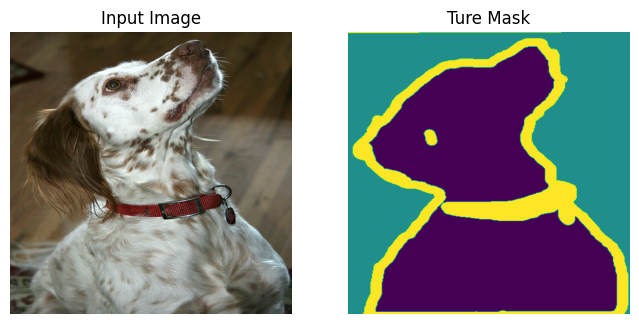

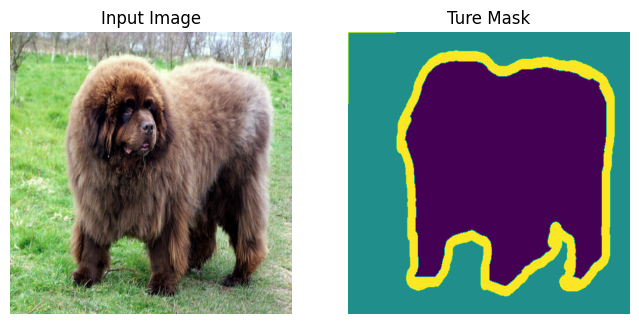

In [11]:
import matplotlib.pyplot as plt
def display(display_list):
  plt.figure(figsize = (8, 8))

  title = ['Input Image', 'Ture Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i + 1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

for sample in train_ds.take(2):
  sample_img, sample_mask = sample['pixel_values'][0], sample['labels'][0]
  sample_img = tf.transpose(sample_img, (1, 2,0))
  sample_mask = tf.expand_dims(sample_mask, -1)
  display([sample_img, sample_mask])

## Load a pretrained SegFormer checkpoint

In [13]:
from transformers import TFSegformerForSemanticSegmentation

model_checkpoints = "nvidia/mit-b0"
id2label = {0: "outer", 1: "inter", 2: "border"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoints,
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True,
)

Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
lr = 0.00006
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr))

## CallBacks

In [16]:
from IPython.display import clear_output
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis = 1)
  pred_mask = tf.expand_dims(pred_mask, -1)
  return pred_mask[0]

def show_prediction(dataset=None, num=1):
  if dataset:
    for sample in dataset.take(num):
      images, masks = sample['pixel_values'], sample['labels']
      masks = tf.expand_dims(masks, -1)
      pred_mask = model.predict(images).logits
      images = tf.transpose(images, (0, 2, 3, 1))
      display([images[0], masks[0], create_mask(pred_mask)])
  else:
    display(
        [
            sample_image,
            sample_mask,
            create_mask(model.predict(tf.expand_dims(sample_image, 0)))
        ]
    )

class DisplayCallback(tf.keras.callbacks.Callback):
  def __init__(self, dataset, **kwargs):
    super().__init__(**kwargs)
    self.dataset = dataset

  def epoch_end(self, epoch, logs = None):
    clear_output(wait=True)
    show_prediction(self.dataset)
    print("\nSample Prediction after epoch {}\n".format(epoch + 1))

In [18]:
epochs = 5
history = model.fit(
    train_ds,
    validation_data = test_ds,
    callbacks=[DisplayCallback(test_ds)],
    epochs = epochs
)

Epoch 1/5
920/920 [==============================] - 414s 384ms/step - loss: 0.3362 - val_loss: 0.2198
Epoch 2/5
920/920 [==============================] - 347s 377ms/step - loss: 0.2248 - val_loss: 0.2025
Epoch 3/5
920/920 [==============================] - 345s 375ms/step - loss: 0.1968 - val_loss: 0.2107
Epoch 4/5
920/920 [==============================] - 344s 374ms/step - loss: 0.1848 - val_loss: 0.1917
Epoch 5/5
920/920 [==============================] - 343s 372ms/step - loss: 0.1728 - val_loss: 0.1901


1/1 [==============================] - 3s 3s/step


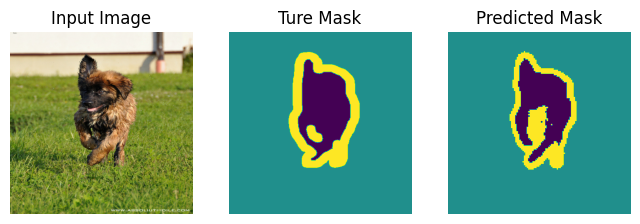

1/1 [==============================] - 0s 145ms/step


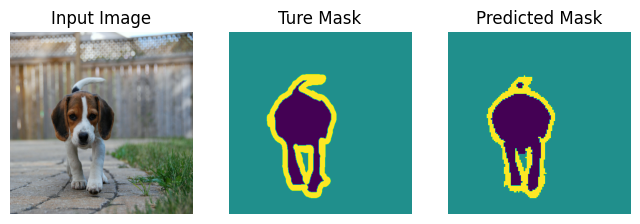

1/1 [==============================] - 0s 117ms/step


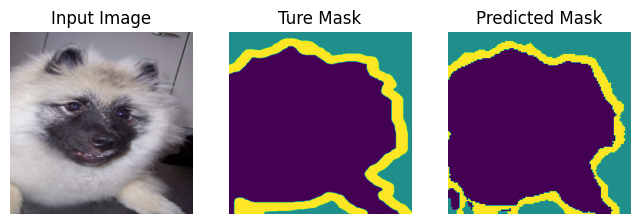

In [19]:
show_prediction(test_ds, 3)